In [ ]:
!pip install -q xlrd
!git clone https://github.com/shreyas-bk/without_mask.git #dataset with 674 images of faces withput masks, which i got from https://github.com/prajnasb/observations/tree/master/experiements/data/without_mask

Cloning into 'without_mask'...
remote: Enumerating objects: 677, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 677 (delta 0), reused 0 (delta 0), pack-reused 674
Receiving objects: 100% (677/677), 24.24 MiB | 32.91 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import argparse
import os

**SETUP**

*ENTER YOUR NAME*

In [ ]:
name = 'Thanujas' #Required to save the images properly

*Requirement: 1 PICTURE WITH A FACEMASK AND 1 WITHOUT A FACEMASK*

*Use one of the 2 methods given below*




*Method 2: Take pictures by running the next 2 cells*


For best results make sure the input images are similar to these:


*   [Without mask](https://github.com/shreyas-bk/Personal_Face_Mask_Detection_V3/blob/master/Shreyas_without_mask%20(1).jpg)
*   [With mask](https://github.com/shreyas-bk/Personal_Face_Mask_Detection_V3/blob/master/Shreyas_with_mask%20(1).jpg)



*WITHOUT MASK*

<IPython.core.display.Javascript object>

Saved to Thanujas_without_mask.jpg


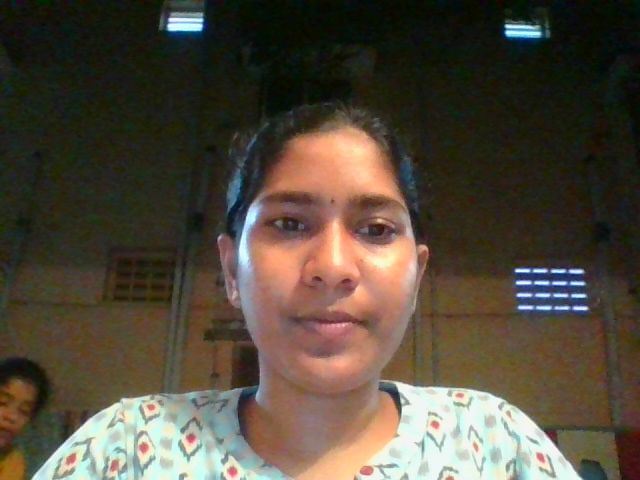

In [ ]:
#WITHOUT MASK
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=name+'_without_mask.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Take picture without mask';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

*WITH MASK*

In [ ]:
#WITH MASK
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=name+'_with_mask.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Take picture with mask';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

'NoneType' object has no attribute 'split'


**Approach**

*   First model works to identify if there is a mask or not. It uses the without mask dataset that was downloaded as well as augmented images of the user's without mask image for negative cases and augmented images of the user's with mask image for positive cases. However, in some cases, since the mask obscures features of the face, it may predict that someone else wearing a mask is a positive case, which shoudln't happen since it's meant to be personalized. So I made a second model which solves that. (Note: The first model is the first factor that needs to be passed in order to move to the second model.)

*   The second model takes instances of the without mask dataset as negative cases and both the user's with mask and without mask images as positive cases. So once the first factor is passed, this model makes sure that it is actually the given user with a mask. If the input passes this second factor, access is granted.



**MASK DETECTION**

*Factor 1*

*Load data*

In [ ]:
data = []
labels = []
count = 0
for imagePath in list(paths.list_images('/content/')):
  count+=1
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  if imagePath=='/content/'+name+'_without_mask.jpg':
    datagen = ImageDataGenerator(zoom_range=0.2,height_shift_range=40)
    i=0
    lis = []
    img = load_img(imagePath, target_size=(224, 224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1):
      image = img_to_array(batch[0])
      image = preprocess_input(image)
      count+=1
      label = 'without-mask'
      data.append(image)
      labels.append(label)
      i += 1
      if i >= 100:
        break
  if imagePath=='/content/'+name+'_with_mask.jpg':
    datagen = ImageDataGenerator(zoom_range=0.4,height_shift_range=40,brightness_range=[0.5,1.5])
    i=0
    lis = []
    img = load_img(imagePath, target_size=(224, 224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1):
      image = img_to_array(batch[0])
      image = preprocess_input(image)
      count+=1
      label = 'with-mask'
      data.append(image)
      labels.append(label)
      i += 1
      if i >= 500:
        break
  else:
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print('Loading complete for ',count,' images')

Loading complete for  1289  images


*Train model*

In [ ]:
aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)), # 5 convolutional layers
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')>1):
      print('\nLoss too high, try rerunning cell')
      self.model.stop_training = True
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nStopping training with accuracy of >95%")
      self.model.stop_training = True

BS = 32
EPOCHS = 20
callback = myCallback()
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  callbacks = [callback])
tf.keras.backend.clear_session()

ValueError: ignored

**PERSONAL DETECTION**

*Factor 2*

*Load data*

In [ ]:
person_data = []
person_labels = []
count = 0
for imagePath in list(paths.list_images('/content/')):
  count+=1
  label = 'not-self'
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  if imagePath=='/content/'+name+'_without_mask.jpg':
    for i in range(0,300):
      count+=1
      label = 'self'
      person_data.append(image)
      person_labels.append(label)
  if imagePath=='/content/'+name+'_with_mask.jpg':
    for i in range(0,300):
      count+=1
      label = 'self'
      person_data.append(image)
      person_labels.append(label)
  else:
    person_data.append(image)
    person_labels.append(label)
person_data = np.array(person_data, dtype="float32")
person_labels = np.array(person_labels)
lb = LabelBinarizer()
person_labels = lb.fit_transform(person_labels)
person_labels = to_categorical(person_labels)
print('Loading complete for ',count,' images')

Loading complete for  1289  images


*Train model*

In [ ]:
#person_model
aug = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest')
(trainX, testX, trainY, testY) = train_test_split(person_data, person_labels,
	test_size=0.20, stratify=person_labels, random_state=42)
import tensorflow as tf
person_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)), # 4 convolutional layers
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

from tensorflow.keras.optimizers import RMSprop

person_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')>1):
      print('\nLoss too high, try rerunning cell') # Sometimes, if intial loss is too high, it kees getting higher; running the cell again and having a smaller inital oss seems to work better
      self.model.stop_training = True
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.97):
      print("\nStopping training with accuracy of >97%")
      self.model.stop_training = True

BS = 32
EPOCHS = 20
callback = myCallback()
H = person_model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  callbacks = [callback])
tf.keras.backend.clear_session()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
32/32 [==============================] - 11s 308ms/step - loss: 0.3220 - accuracy: 0.8717 - val_loss: 0.0700 - val_accuracy: 0.9612
Epoch 2/20
32/32 [==============================] - 10s 322ms/step - loss: 0.1388 - accuracy: 0.9399 - val_loss: 0.1634 - val_accuracy: 0.9457
Epoch 3/20
32/32 [==============================] - 10s 298ms/step - loss: 0.1105 - accuracy: 0.9529 - val_loss: 0.1041 - val_accuracy: 0.9690
Epoch 4/20
32/32 [==============================] - 10s 298ms/step - loss: 0.1597 - accuracy: 0.9649 - val_loss: 0.0228 - val_accuracy: 0.9961
Epoch 5/20
32/32 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9770
Stopping training with accuracy of >97%
32/32 [==============================] - 10s 300ms/step - loss: 0.0617 - accuracy: 0.9770 - val_loss: 0.0477 - val_accuracy: 0.9922


*Check confidence of models*

In [ ]:
image = load_img('/content/'+name+'_with_mask.jpg', target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
to_predict = []
to_predict.append(image)
to_predict = np.array(to_predict, dtype="float32")
print('Picture with mask')
print('Factor 1 confidence : ',round(max(model.predict(to_predict)[0]),3))
print('Factor 2 confidence : ',round(max(person_model.predict(to_predict)[0]),4))
image = load_img('/content/'+name+'_without_mask.jpg', target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
to_predict = []
to_predict.append(image)
to_predict = np.array(to_predict, dtype="float32")
print('\nPicture without mask')
print('Factor 1 confidence : ',round(max(model.predict(to_predict)[0]),3))
print('Factor 2 confidence : ',round(max(person_model.predict(to_predict)[0]),4))
print('\nFactor 1 confidences should be greater than 0.95 and Factor 2 confidences should be greater than 0.98')

Picture with mask
Factor 1 confidence :  1.0
Factor 2 confidence :  1.0

Picture without mask
Factor 1 confidence :  1.0
Factor 2 confidence :  1.0

Factor 1 confidences should be greater than 0.95 and Factor 2 confidences should be greater than 0.98


**TEST THE MODELS**

*Set minimum confidence - default is 95% for first factor and 99% for second factor*

In [ ]:
CONFIDENCE = 0.95
CONFIDENCE2 = 0.99



Mask detected with  99.99 % confidence.

Details:
First factor - Passing.
Second factor - Passing.



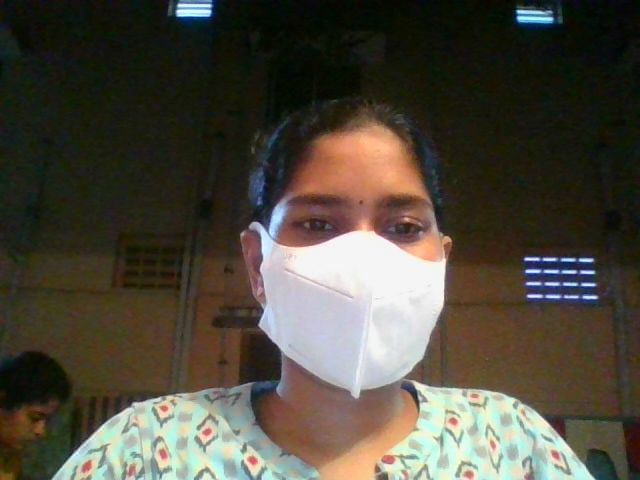

Access Granted


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      //setTimeout(() => {  console.log("World!"); }, 10000);
      //const promise = new Promise((resolve, reject) => {
      //setTimeout(() => {
       //resolve() // Change status to 'fulfilled'
      //}, 5000)
      //})
      //await promise
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
from IPython.display import clear_output
import time
try:
  factor1,factor2='without mask','not self'
  print('\nWear your mask to access')
  start_flag=True
  while(factor1=='without mask' or factor2=='not self'):
    if start_flag==False:
      clear_output()
      if prelim=='with mask' and factor1=='without mask':
        print('\nMask detected with low confidence (',round((confidence-0.5)*100,2),'%). Try coming closer to the camera and making sure the mask is covering your nose.')
      if factor1=='without mask' and prelim=='without mask':
        print('\nNo mask detected - Please wear a mask over your nose and mouth.')
      print('\nDetails:\nFirst factor - ','Passing' if factor1=='with mask' else 'Failing',('\nSecond factor - ','Passing\n' if factor2=='self' else 'Failing\n') if factor1=='with mask' else '\n')
    filename = take_photo()
    image = load_img('/content/photo.jpg', target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    to_predict = []
    to_predict.append(image)
    to_predict = np.array(to_predict, dtype="float32")
    factor1 = 'without mask' if model.predict(to_predict)[0][0]<CONFIDENCE else 'with mask'
    prelim = 'without mask' if model.predict(to_predict)[0][0]<0.5 else 'with mask'
    confidence = max(model.predict(to_predict)[0])
    factor2 = 'not self' if person_model.predict(to_predict)[0][1]<CONFIDENCE2 else 'self'
    start_flag=False
  clear_output()
  print('\n\nMask detected with ',round(confidence*100,2),'% confidence.\n\nDetails:\nFirst factor - Passing.\nSecond factor - Passing.\n')
  display(Image(filename))
  print('Access Granted')
except Exception as err:
  print(str(err))